In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, cross_validation, linear_model

import smap
%matplotlib inline

- Import ground-truth map of VAV/room to AHU

In [318]:
map_ahu_rooms=pd.read_csv("ahumapping-full",header =None, names=['room','ahu'])
#remove spaces
map_ahu_rooms.room = map_ahu_rooms.room.map(str.strip)
map_ahu_rooms=map_ahu_rooms.set_index('room')
new_room = map_ahu_rooms.sort()

- Import list of names of AHU 'supply air temperature' files

In [3]:
ahu_SAT = glob.glob('*SAT*')
ahu_SAT

['STAA1_AVG__SAT',
 'STAA2_AVG__SAT',
 'STAA3_AVG__SAT',
 'STAA4_AVG__SAT',
 'STAA5_AVG__SAT']

- Import list of names of AHU 'supply air temperature setpoint' files

In [4]:
ahu_SAS = glob.glob('*SAS*')
#ahu_SAS

- Import OAT

In [5]:
oat = glob.glob('*OAT*')
oat

['STA_BLD_X__OAT']

- Import list of files in the directory and extract room and sensor

In [6]:
filenames = glob.glob('STA*')
df=pd.DataFrame(filenames, columns=["filename"])
start = '_'
end = '__'
df=df.merge(df.filename.apply(lambda s: pd.Series({'room':s.split(start)[1].split(end)[0],'sensor':s.split(end)[-1].split(start)[-1]})), 
    left_index=True, right_index=True)
df.head()

,filename,room,sensor
0,STA_100____ARS,100,ARS
1,STA_100____ART,100,ART
2,STA_100____RVP,100,RVP
3,STA_100___SDVP,100,SDVP
4,STA_100___SVEL,100,SVEL


- Rename sensor with multiple names

In [7]:
df=df.replace({'sensor' : {'RHV':'RVP','PHSF':'SVEL', 'PHSC':'SVES'}})

- Exclude rooms with multiple VAV box and no damper

In [8]:
lim=df.groupby(df.room).count() == 6 # 6 sensors (=6 lines or files)
lim_list=lim[lim.filename == True].index
cond = (df.room.isin(lim_list)) & ((df.sensor == "ARS") | (df.sensor == "ART") | (df.sensor == "RVP") |(df.sensor == "SDVP") | (df.sensor == "SVEL") | (df.sensor == "SVES"))
df=df[cond]

df.head()
#df.shape

,filename,room,sensor
0,STA_100____ARS,100,ARS
1,STA_100____ART,100,ART
2,STA_100____RVP,100,RVP
3,STA_100___SDVP,100,SDVP
4,STA_100___SVEL,100,SVEL


- Count # room left in the list

In [9]:
rooms=df.room.unique()
np.count_nonzero(rooms)

179

The following code :
- identifies rooms
- loops the rooms and scan the sensor file names
- loops the filenames and builds a data_table (sensor in columns, readings in rows)
- loops ahu and couples the room sensors with ahu, then it creates a regression of indoor temperature for each pair
- saves the R^2 results of each regression in a table and append the ground-truth ahu connected

In [10]:
#initialize dataframes
scores=pd.DataFrame()
data_tot=pd.DataFrame()

#find rooms in the list of sensors
rooms=df.room.unique()

#set periods for training and validation periods; here the validation period for ahu 2 contains the perturbation
tr_per=(slice(None),slice(pd.Timestamp('2015-05-30 10:08:07-7:00'),pd.Timestamp('2015-06-09 09:24:34-7:00')))
val_per=(slice(None),slice(pd.Timestamp('2015-05-28 03:31:09-07:00'),pd.Timestamp('2015-05-30 10:08:00-7:00')))

# for each room (zone) loops and construct a dataframe that has as column the sensors and as rows the readings
for room in rooms:
    filenames=np.concatenate((df[df.room==room].filename.values , oat, ahu_SAT, ahu_SAS), axis=0)
    colnames=np.concatenate((df[df.room==room].sensor.values , oat, ahu_SAT, ahu_SAS), axis=0)
    #initialize the dataframe for the specific room at each loop
    data_table = pd.DataFrame()
    #loop filenames (senosors)
    for filename in filenames:
        #open csv containing data for that sensor
        data=pd.read_csv(filename,header =None, index_col =0, names = ['time',filename]).sort()
        #convert time and set it as index
        data.index=pd.to_datetime(data.index, unit='s',).tz_localize('UTC').tz_convert('America/Los_Angeles')
        # join data from single sensor with the other data from the other sensor for the same room
        data_table = data_table.join(data,how='outer')

    #change column name from file to sensor name at the end of the loop
    data_table.columns = colnames
    
    #the following line group by 5 min, interpolate linearly the results and drop the remaining na at the beginning
    #of the data_table. This is required to pass data to sklearn
    data_table=data_table.groupby(pd.TimeGrouper('5Min')).mean().interpolate(method='time').dropna()

    #save room number as additional index. This is done to save the data_tot file and distinguish the rooms
    data_table['room']=room
    data_table.set_index('room', append =True, inplace =True)
    data_table=data_table.reorder_levels([1,0], axis=0)
    ##print room
    
    #save all the data_tables per room into a large dataset
    data_tot=data_tot.append(data_table)    
    
    ##if room == '100':
    ##    print data_tot
    ##print room
    
    # we want to send sci-kit learn a matrix that contains sensors variable in columns and timeseries in rows
    # we pair each room sensor group with one ahu and send it to the regression, retrieving R^2
    # we expect that the regression with the actual ahu they are connected to has higher R^2

    for ahu_SAT_ in ahu_SAT:
        #TRAINING DATA
        ##data_training=data_table.loc[tr_per,['RVP','SDVP','SVEL',ahu_SAT_,'STA_BLD_X__OAT']]
        data_training=data_table.loc[tr_per,['ART','SDVP','SVEL',ahu_SAT_,'STA_BLD_X__OAT']]
        
        ###name the column appriopiately
        ###data_training.columns=['ART-1']
        # calculate T_room(t-1) and build the complete table of the training set
        #data_training=data_training.join(data_table.loc[tr_per,['ART']].shift(1).fillna(method='bfill'))
        target_training=data_table.loc[tr_per,['RVP']]
        #turn data into np arrays to pass to sklearn
        data_training_ar=data_training.values
        target_training_ar=target_training.values

        #VALIDATION DATA
        data_validation=data_table.loc[tr_per,['ART','SDVP','SVEL',ahu_SAT_,'STA_BLD_X__OAT']]
        ###name the column appriopiately
        ###data_training.columns=['ART-1']
        # calculate T_room(t-1) and build the complete table of the training set
        #data_validation=data_validation.join(data_table.loc[tr_per,['ART']].shift(1).fillna(method='bfill'))
        target_validation=data_table.loc[tr_per,['RVP']]
        #turn data into np arrays to pass to sklearn
        data_validation_ar=data_validation.values
        target_validation_ar=target_validation.values
            
        #call regression
        clf = linear_model.LinearRegression()
        scores.ix[room,ahu_SAT_]=clf.fit(data_training_ar,target_training_ar).score(data_validation_ar,target_validation_ar)
        
        ##print clf.coef_
scores.index.name='room'
scores=scores.join(map_ahu_rooms, how='left').sort('ahu')
scores.to_csv('scores.csv')
scores

,STAA1_AVG__SAT,STAA2_AVG__SAT,STAA3_AVG__SAT,STAA4_AVG__SAT,STAA5_AVG__SAT,ahu
room,,,,,,
B357,0.308969,0.308923,0.310445,0.315546,0.324389,1
227B,0.487571,0.488126,0.488381,0.491135,0.499014,1
225,0.606964,0.607573,0.609157,0.619054,0.632344,1
325,0.107481,0.107182,0.107451,0.110470,0.115352,1
425,0.267393,0.270211,0.268753,0.281166,0.273986,1
223,0.368168,0.368173,0.372697,0.384921,0.428204,1
125,0.733799,0.733814,0.733891,0.733864,0.733799,1
123,0.041237,0.041158,0.042080,0.045910,0.061837,1
371,0.070573,0.070762,0.075379,0.099338,0.088306,1


In [11]:
scores.to_csv('scores.csv')
scores

,STAA1_AVG__SAT,STAA2_AVG__SAT,STAA3_AVG__SAT,STAA4_AVG__SAT,STAA5_AVG__SAT,ahu
room,,,,,,
B357,0.308969,0.308923,0.310445,0.315546,0.324389,1
227B,0.487571,0.488126,0.488381,0.491135,0.499014,1
225,0.606964,0.607573,0.609157,0.619054,0.632344,1
325,0.107481,0.107182,0.107451,0.110470,0.115352,1
425,0.267393,0.270211,0.268753,0.281166,0.273986,1
223,0.368168,0.368173,0.372697,0.384921,0.428204,1
125,0.733799,0.733814,0.733891,0.733864,0.733799,1
123,0.041237,0.041158,0.042080,0.045910,0.061837,1
371,0.070573,0.070762,0.075379,0.099338,0.088306,1


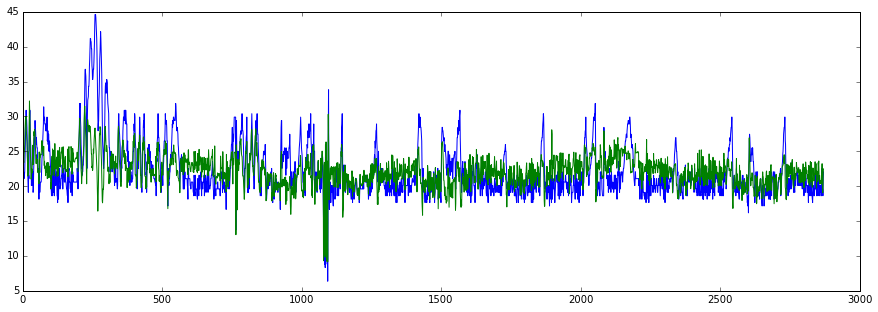

In [12]:

prediction_val = clf.predict(data_validation_ar)
plt.figure(figsize=(15,5))
plt.plot(target_training_ar )
plt.plot(prediction_val)

In [13]:
room


'B357'

to do next:
- check if dates are correct - OK
- check sampling time - Arka
- separate training and validation - OK
- look for relevant variables (take variables out)
- regress RVP instead -OK
- test other regression models 
- change interval to 15 min - OK
- plot and save to compare
- classify rooms by type



#Miguel's Part Begins

###RVP analysis

- created a means table, which contains means of RVP values
- created plot of the data as requested. seems to check out
- this is later redone using 25% and 75% instead of STD values

In [307]:

#Here we take the RVP values for each room and get the mean and std for each. then, create table.
means_table = data_tot['RVP'].groupby(level='room').describe().unstack()[['mean','std']].sort(columns = 'mean',ascending = False)
means_table["mean - std"] = means_table['mean'] - means_table['std']
means_table["mean + std"] = means_table['mean'] + means_table['std']
means_table=means_table.join(map_ahu_rooms)
#means_table

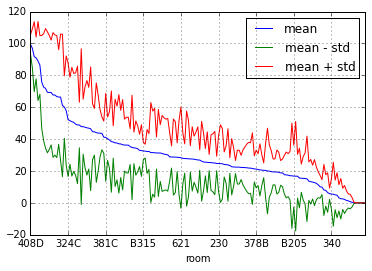

In [91]:
table_to_plot = means_table.drop(['ahu','std'],axis=1)
plt.figure;table_to_plot.plot()


###Below, I first create tables with the 25%, mean, 75% for each sensor, then join into one table

In [234]:
# create tables
percentile_table_RVP = data_tot['RVP'].groupby(level='room').describe().unstack()[['25%','mean', '75%']].sort(columns = 'mean',ascending = False)
percentile_table_RVP.columns = ['25%_RVP', 'mean_RVP','75%_RVP']

percentile_table_SVES = data_tot['SVES'].groupby(level='room').describe().unstack()[['25%','mean','75%']].sort(columns = 'mean',ascending = False)
percentile_table_SVES.columns = ['25%_SVES', 'mean_SVES', '75%_SVES']

percentile_table_SVEL = data_tot['SVEL'].groupby(level='room').describe().unstack()[['25%','mean','75%']].sort(columns = 'mean',ascending = False)
percentile_table_SVEL.columns = ['25%_SVEL','mean_SVEL','75%_SVEL']

percentile_table_SDVP = data_tot['SDVP'].groupby(level='room').describe().unstack()[['25%','mean','75%']].sort(columns = 'mean',ascending = False)
percentile_table_SDVP.columns = ['25%_SDVP','mean_SDVP', '75%_SDVP']

percentile_table_ART = data_tot['ART'].groupby(level='room').describe().unstack()[['25%','mean','75%']].sort(columns = 'mean',ascending = False)
percentile_table_ART.columns = ['25%_ART','mean_ART','75%_ART']

####Here they are joined

In [308]:
percentile_table_all = pd.concat([percentile_table_ART,percentile_table_RVP,percentile_table_SDVP,percentile_table_SVEL,percentile_table_SVES], axis = 1)
#percentile_table_all.to_csv('out.csv')
#percentile_table_all[['25%_SVEL', 'mean_SVEL','75%_SVEL']] #display the table


###Further Analyze the RVP data and assign values of 'min-max', 'no-reheat', 'reheat-only', and 'normal' to means

- min-max is when the 25% is at 0 (or below) and for same room the 75% is at 100 (or close enough)
- no-reheat is when the room is always cooling
- reheat-only is when the room is always reheating the air
- normal is when we fluctate from heating and cooling in the room (as it should be)

In [220]:
# define my functions for analysis of RVP
def RVP_25(x):
    if x <= 5:
        return True
    return False
def RVP_75(x):
    if x >= 90:
        return True
    return False
def RVP_analyze(noheat,heat):
    if noheat and heat:
        return 'min-max'
    elif noheat:
        return 'no-reheat'
    elif heat:
        return 'reheat-only'
    else: return 'normal'

In [239]:
noheat = percentile_table_all[['25%_RVP']].applymap(RVP_25)
heat = percentile_table_all[['75%_RVP']].applymap(RVP_75)
analysis = np.vectorize(RVP_analyze)(noheat,heat)
percentile_table_all['analysis_RVP'] = analysis
#percentile_table_all

In [309]:
#percentile_table_all.groupby('analysis_RVP').count() #for is I want to count the number for each label

###Here is an analysis of the SVEL values, done in a similar fashion as RVP, with labeling as 'variable' and 'fixed'

- variable means that the SVEL is changing by more than 10% of its average value
- fixed means that the SVEL is basically fixed (less than 10% change)

In [240]:
def SVEL_25(x,means): # checks if the 25% is lower than mean - (10% of mean) inputs (x = 25%), (means)
    if x <= (means - (.1 * means)):
        return True
    return False
        
def SVEL_75(x,y):
    if x <= (means + (.1 * means)):
        return True
    return False

def SVEL_analyze(x,y):
    if x or y:
        return 'variable'
    else: 
        return 'fixed'

In [312]:
x = np.vectorize(SVEL_25)(percentile_table_all['25%_SVEL'],percentile_table_all['mean_SVEL'])
y = np.vectorize(SVEL_25)(percentile_table_all['75%_SVEL'],percentile_table_all['mean_SVEL'])
analysis_SVEL = np.vectorize(SVEL_analyze)(x,y)
percentile_table_all['analysis_SVEL'] = analysis_SVEL
#percentile_table_SVEL

###Here I am trying to figure out what is wrong with the SVES or SVEL sensors. We have some strange values, and want to figure out what is wrong

First create a table that has the means of the SVES and SVEL tables, and compare to see if theres some sort of correlation/relation that we can notice between those groups whose values are (obviously) off/wrong

In [299]:
percentile_table_SVEL['SVES_mean'] = percentile_table_SVES['mean_SVES']
status_check_table = percentile_table_SVEL[['SVES_mean','mean_SVEL']]

In [305]:
def status_check(x,y):
    if (abs(x - y)) <= (.3 * x):
        return 'ok'
    return 'broken'

In [306]:
status_check = np.vectorize(status_check)(status_check_table['SVES_mean'],status_check_table['mean_SVEL'])


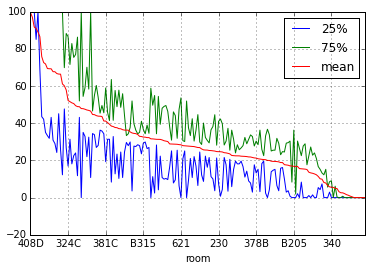

In [97]:
plt.figure;percentile_table.plot()

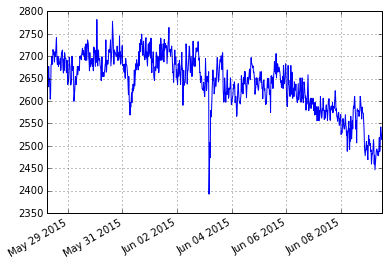

In [275]:
data_tot.loc['482']['SVEL'].plot() 

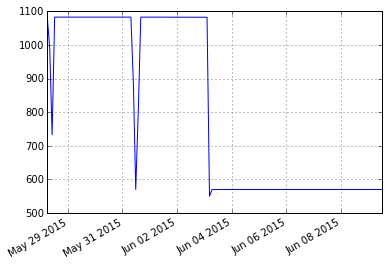

In [276]:
data_tot.loc['482']['SVES'].plot()

###Below is attempt at creating a single graph with the boxplots for RVP values

- instead of creating many box plots on one graph, we have them all in their own graph :-(

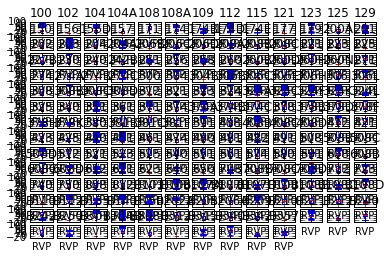

In [320]:
temp_frame = data_tot[['RVP']]

tempgroup = temp_frame.loc[new_room.index[0]]

box_axes = tempgroup.boxplot(return_type = 'axes')

grouped = temp_frame.groupby(level='room')
plt.figure; grouped.boxplot(ax = box_axes)
plt.show()

In [80]:
map_ahu_rooms.index[0]

'231B'

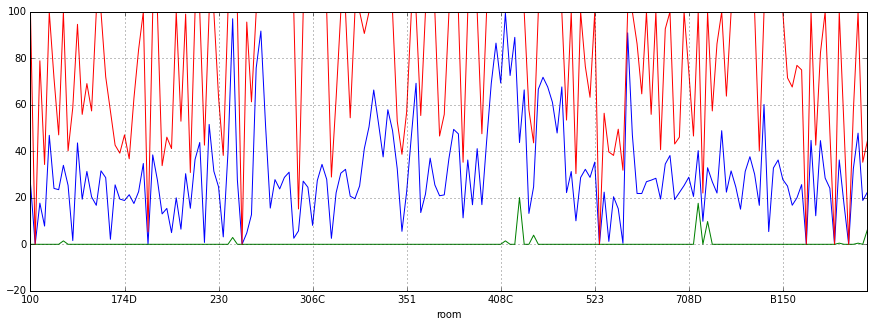

In [306]:
plt.figure(figsize=(15,5))
data_tot['RVP'].groupby(level='room').mean().plot()
data_tot['RVP'].groupby(level='room').min().plot()
data_tot['RVP'].groupby(level='room').max().plot()
#data_tot['RVP'].groupby(level='room').boxplot()

